In [26]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [27]:
train = pd.read_csv("/kaggle/input/mnist-in-csv/mnist_train.csv")
test = pd.read_csv("/kaggle/input/mnist-in-csv/mnist_test.csv")

print("Train_shape:",train.shape)
print("Test_shape:",test.shape)
print("columns:",train.columns.tolist()[:10],"...total",len(train.columns))

Train_shape: (60000, 785)
Test_shape: (10000, 785)
columns: ['label', '1x1', '1x2', '1x3', '1x4', '1x5', '1x6', '1x7', '1x8', '1x9'] ...total 785


In [28]:
print(train.head(5))

   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]


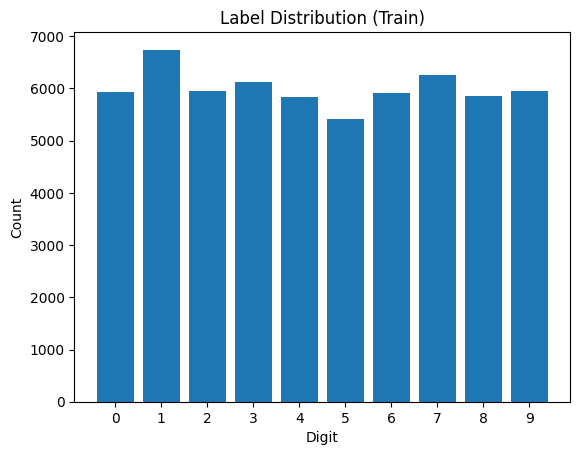

In [29]:
label_counts = train['label'].value_counts().sort_index()
plt.figure()
plt.bar(label_counts.index.astype(str), label_counts.values)
plt.title('Label Distribution (Train)')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()


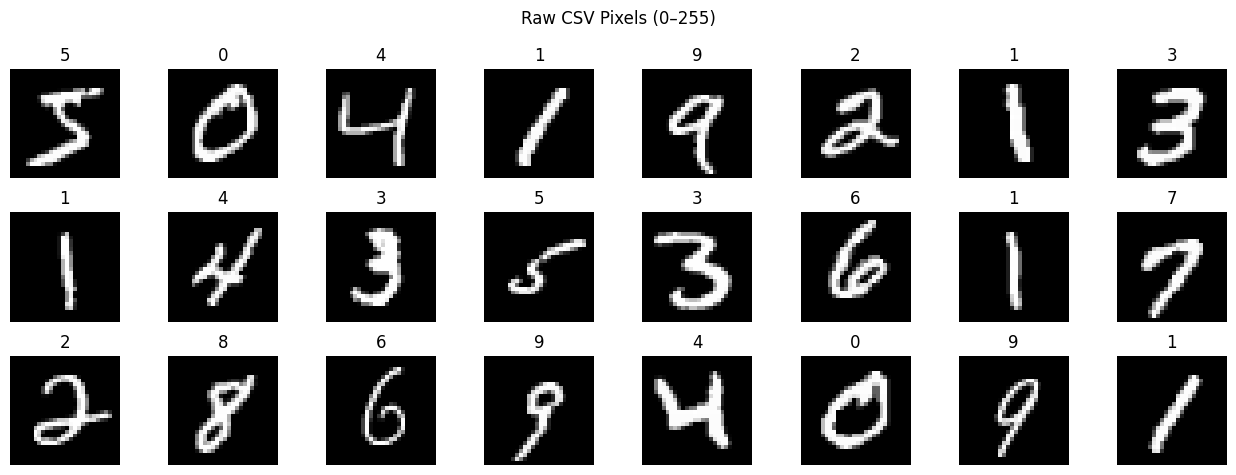

In [30]:
def plot_digits_grid(images,labels,n,cols,title):
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols * 1.6, rows * 1.6))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if labels is not None:
            plt.title(str(labels[i]))
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Show a few raw samples from the CSV
X_preview = train.drop('label', axis=1).values
y_preview = train['label'].values
plot_digits_grid(X_preview, y_preview, n=24, cols=8, title='Raw CSV Pixels (0–255)')

In [31]:
X = train.drop('label',axis=1).values.astype(np.float32)
y = train['label'].values.astype(np.int64)

X_test = test.drop('label',axis=1).values.astype(np.float32)
y_test = test['label'].values.astype(np.int64)


In [32]:
#Normalization
X /= 255.0
X_test /= 255.0

# Reshape to NHWC tensors for CNN (N, 28, 28, 1)
X = X.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

print("After preprocessing:")
print("X:", X.shape, X.dtype)
print("y:", y.shape, y.dtype)
print("X_test_all:", X_test.shape)
print("y_test_all:", y_test.shape)


After preprocessing:
X: (60000, 28, 28, 1) float32
y: (60000,) int64
X_test_all: (10000, 28, 28, 1)
y_test_all: (10000,)


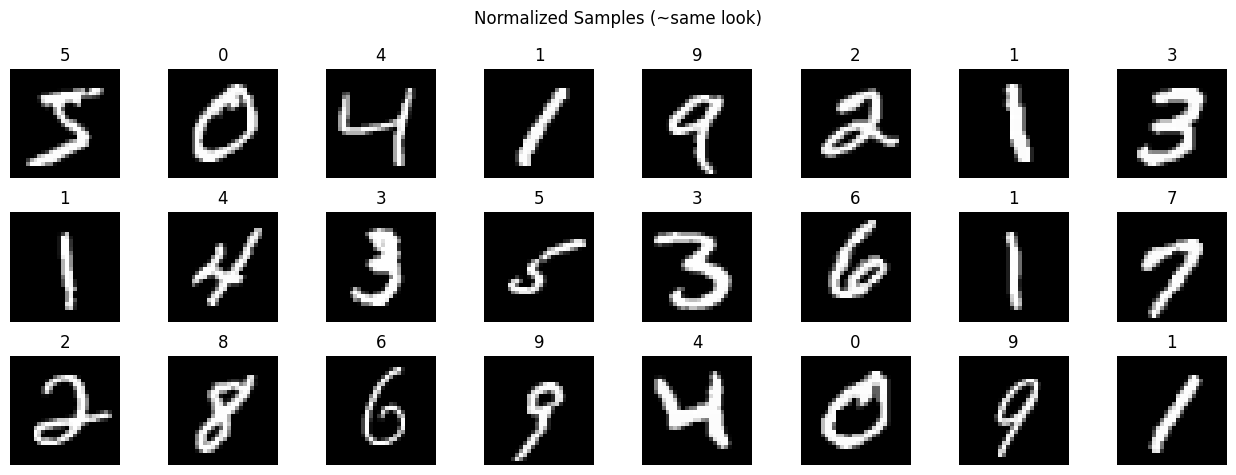

In [33]:
plot_digits_grid((X * 255).astype(np.uint8).reshape(-1, 28*28), y, n=24, cols=8, title='Normalized Samples (~same look)')


"**Stratify =y**"
It tells train_test_split to preserve the class distribution in the train and validation sets.

In other words, if your dataset has 70% of samples as class 0 and 30% as class 1, then both the training and validation sets will keep approximately the same 70/30 ratio.

In [34]:
#Train-Val split
SEED = 32
X_train, X_val, y_train, y_val = train_test_split(X ,y, test_size =0.2, random_state = SEED, stratify=y)
print("Train:", X_train.shape, "Val:", X_val.shape)

Train: (48000, 28, 28, 1) Val: (12000, 28, 28, 1)


In [35]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
# not passing any argument means it only scale the data and to make train and validation on same pipeline
val_datagen = ImageDataGenerator()

In [36]:
train_gen = train_datagen.flow(X_train, y_train, batch_size=128, shuffle=True, seed=SEED)
val_gen   = val_datagen.flow(X_val,   y_val,   batch_size=128, shuffle=False)

In [37]:
def build_model():
    model = models.Sequential([
        layers.Input(shape=(28, 28, 1)),

        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
    
model = build_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
ckpt_path = 'best_mnist.h5'
cb = [
    callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5),
    callbacks.ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, verbose=1)
]

**steps_per_epoch**

steps_per_epoch = how many batches of data the model sees in one epoch.
You have 10,000 training samples, batch size = 128, so normally ~78 steps.

But if you set steps_per_epoch = 20:

Each epoch only sees 20 × 128 = 2560 samples, not the full dataset.
If len(X_train) = 12,000 and batch_size = 300
→ steps_per_epoch = 12000 // 300 = 40
→ One epoch = 40 steps × 300 samples = 12,000 samples.

In [39]:
EPOCHS = 18
STEPS = len(X_train) // 128 
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    steps_per_epoch=STEPS if STEPS > 0 else None,
    validation_data=val_gen,
    callbacks=cb,
    verbose=2
)

Epoch 1/18


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.96942, saving model to best_mnist.h5
375/375 - 27s - 71ms/step - accuracy: 0.8494 - loss: 0.4879 - val_accuracy: 0.9694 - val_loss: 0.0955 - learning_rate: 0.0010
Epoch 2/18

Epoch 2: val_accuracy improved from 0.96942 to 0.97517, saving model to best_mnist.h5
375/375 - 24s - 65ms/step - accuracy: 0.9498 - loss: 0.1646 - val_accuracy: 0.9752 - val_loss: 0.0770 - learning_rate: 0.0010
Epoch 3/18

Epoch 3: val_accuracy improved from 0.97517 to 0.97683, saving model to best_mnist.h5
375/375 - 24s - 64ms/step - accuracy: 0.9626 - loss: 0.1217 - val_accuracy: 0.9768 - val_loss: 0.0710 - learning_rate: 0.0010
Epoch 4/18

Epoch 4: val_accuracy improved from 0.97683 to 0.98567, saving model to best_mnist.h5
375/375 - 24s - 65ms/step - accuracy: 0.9686 - loss: 0.1014 - val_accuracy: 0.9857 - val_loss: 0.0462 - learning_rate: 0.0010
Epoch 5/18

Epoch 5: val_accuracy improved from 0.98567 to 0.98758, saving model to best_mnist.h5
375/375 - 25s - 65ms

Learning Curves

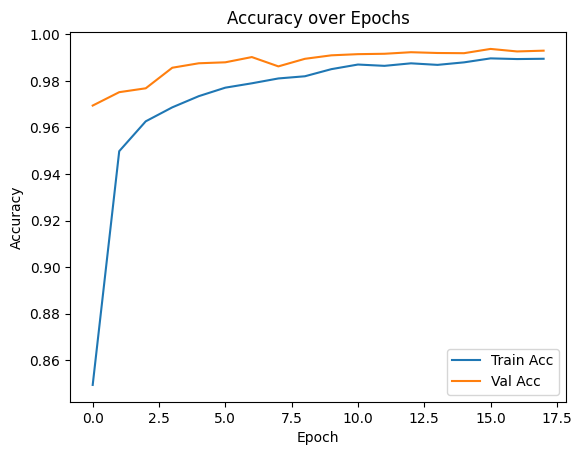

In [40]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

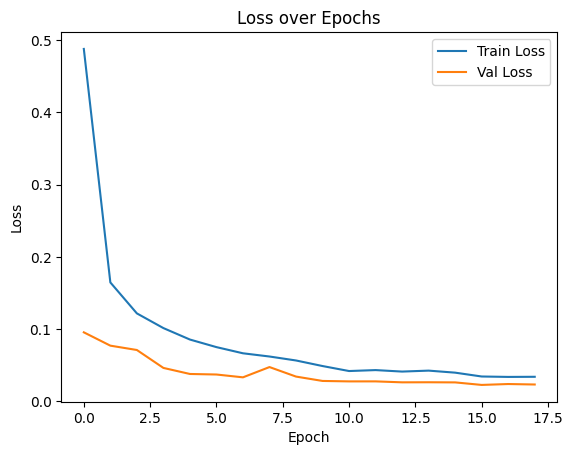

In [41]:
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

Evaluation on Validation and Test

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

val_preds = model.predict(X_val, verbose=0)
val_labels_pred = np.argmax(val_preds, axis=1)
val_acc = accuracy_score(y_val, val_labels_pred)
print(f"Validation accuracy: {val_acc:.4f}")
print(val_labels_pred)

Validation accuracy: 0.9938
[7 9 3 ... 0 3 1]


In [45]:
# Evaluate on the 10k labeled test CSV from this dataset
test_preds = model.predict(X_test, verbose=0)
test_labels_pred = np.argmax(test_preds, axis=1)

test_acc = accuracy_score(y_test, test_labels_pred)
print(f"Test accuracy (mnist_test.csv): {test_acc:.4f}")

print("\nClassification report (Validation):")
print(classification_report(y_val, val_labels_pred, digits=4))

print("\nClassification report (Test):")
print(classification_report(y_test, test_labels_pred, digits=4))

Test accuracy (mnist_test.csv): 0.9934

Classification report (Validation):
              precision    recall  f1-score   support

           0     0.9941    0.9958    0.9949      1185
           1     0.9978    0.9948    0.9963      1348
           2     0.9900    0.9966    0.9933      1192
           3     0.9935    0.9943    0.9939      1226
           4     0.9932    0.9940    0.9936      1168
           5     0.9899    0.9926    0.9912      1084
           6     0.9949    0.9983    0.9966      1184
           7     0.9944    0.9936    0.9940      1253
           8     0.9914    0.9897    0.9906      1170
           9     0.9975    0.9874    0.9924      1190

    accuracy                         0.9938     12000
   macro avg     0.9937    0.9937    0.9937     12000
weighted avg     0.9938    0.9938    0.9937     12000


Classification report (Test):
              precision    recall  f1-score   support

           0     0.9929    0.9969    0.9949       980
           1     0.9965  

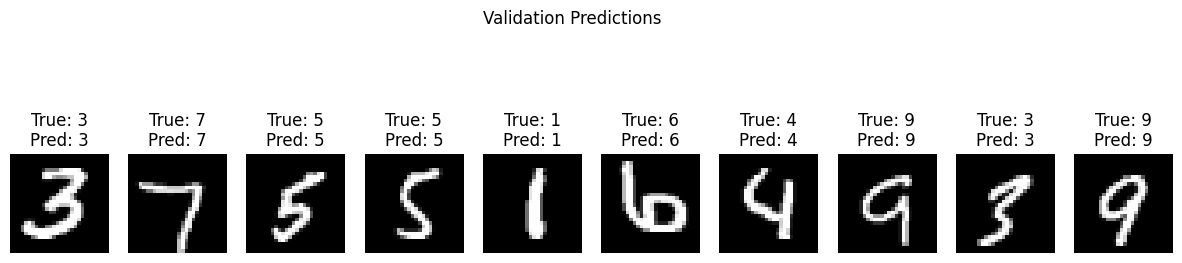

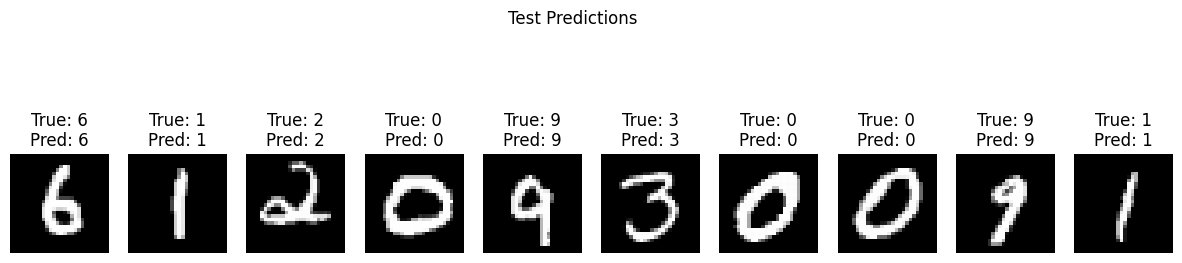

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Show some validation samples with predictions
def show_predictions(X, y_true, y_pred, n=10, title="Validation Samples"):
    plt.figure(figsize=(15, 4))
    indices = random.sample(range(len(X)), n)  # pick n random samples
    
    for i, idx in enumerate(indices):
        plt.subplot(1, n, i + 1)
        plt.imshow(X[idx].reshape(28, 28), cmap="gray")
        plt.title(f"True: {y_true[idx]}\nPred: {y_pred[idx]}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Validation visualization
show_predictions(X_val, y_val, val_labels_pred, n=10, title="Validation Predictions")

# Test visualization
show_predictions(X_test, y_test, test_labels_pred, n=10, title="Test Predictions")


Confusion Matrix (Test)

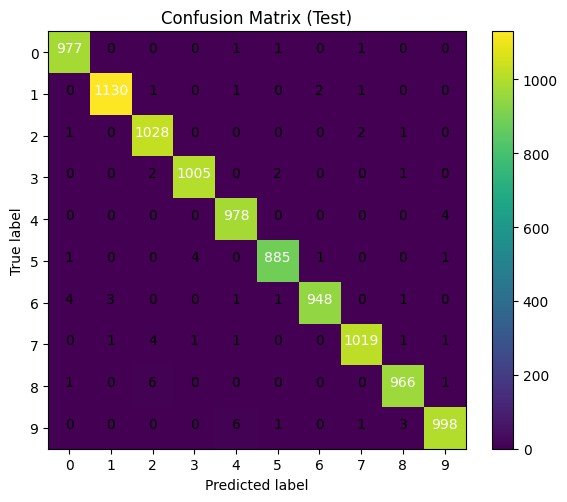

In [50]:
cm = confusion_matrix(y_test, test_labels_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Test)')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Inspect Misclassified Samples (Test)

Misclassified count on test: 66


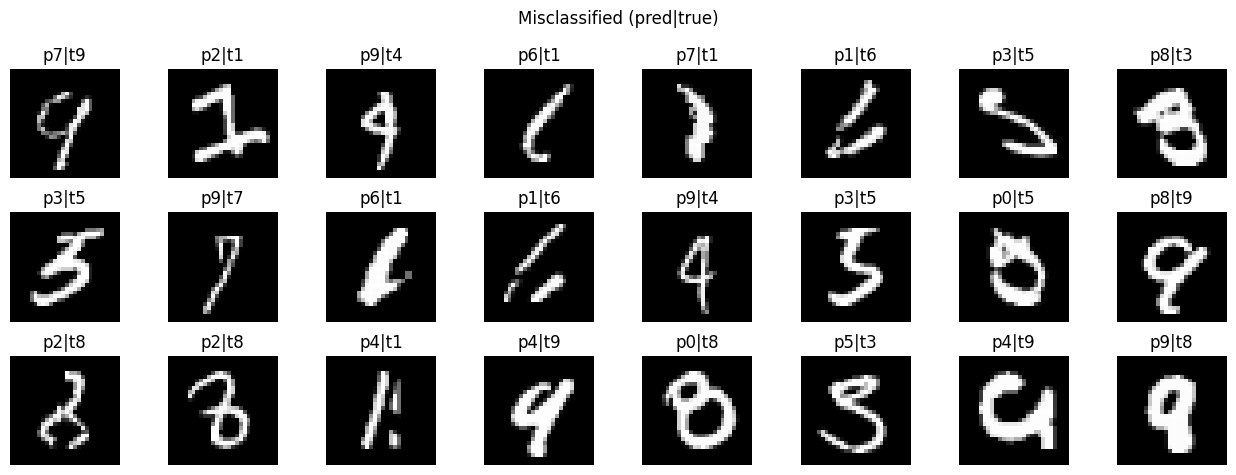

In [54]:
mis_idx = np.where(test_labels_pred != y_test)[0]
print(f"Misclassified count on test: {len(mis_idx)}")
if len(mis_idx) > 0:
    sel = np.random.choice(mis_idx, size=min(24, len(mis_idx)), replace=False)
    plot_digits_grid((X_test[sel] * 255).astype(np.uint8).reshape(-1, 28*28),
                     labels=[f"p{test_labels_pred[i]}|t{y_test[i]}" for i in sel],
                     n=len(sel), cols=8, title='Misclassified (pred|true)')

Pick one random test sample and predict

In [56]:
idx = np.random.randint(0, X_test.shape[0])
sample = X_test[idx:idx+1]
probs = model.predict(sample, verbose=0)[0]
print(f"Random test sample index {idx}: true={y_test[idx]}, pred={np.argmax(probs)}, probs={np.round(probs, 3)}")


Random test sample index 8417: true=7, pred=7, probs=[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [46]:
model.save('mnist_cnn_keras.h5')
print("Saved model to mnist_cnn_keras.h5 and best checkpoint to", ckpt_path)

Saved model to mnist_cnn_keras.h5 and best checkpoint to best_mnist.h5
